# Setup

## Imports

In [1]:
import gym
from vaiutils import plot_image, plot_images, path_consts, smooth_plot, merge
from scipy.misc import imresize
from time import time
from tqdm import tqdm_notebook
from os.path import exists
from imageio import mimsave as gifsave

Keras Modules

In [2]:
import keras.backend as K
from keras.models import Sequential, Model
from keras.layers import Conv2D, Dense, Flatten, LSTM, BatchNormalization, Input
from keras.backend import clear_session
from keras.layers.merge import Concatenate
from keras.utils.np_utils import to_categorical
from keras_tqdm import TQDMNotebookCallback

Using TensorFlow backend.


## Define useful variables and functions

In [3]:
for k, v in path_consts('Pong-Rec'):
    exec(k + '=v')

In [4]:
env = gym.make('Pong-v0')

[2017-09-11 14:06:15,669] Making new env: Pong-v0


In [5]:
env.unwrapped.get_action_meanings()

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

In [6]:
def norm_action(action):
    if action == 0 or action == 1:
        return 0
    elif action == 2 or action == 4:
        return 1
    elif action == 3 or action == 5:
        return 2

In [7]:
def denorm_action(action):
    if action == 0:
        return 0
    else:
        return action + 1

In [8]:
def meaning(normed_action):
    if normed_action == 0:
        return 'Nothing'
    elif normed_action == 1:
        return 'Up'
    elif normed_action == 2:
        return 'Down'

In [9]:
def refine_observation(observation):
    res_img = observation[34:192, 1:-1].mean(2)
    res_img[res_img < 100] = 0
    res_img[res_img > 100] = 255

    white_pos = np.where(res_img == 255)
    l_cols = (white_pos[1] > 14) & (white_pos[1] < 19)
    if np.any(l_cols):
        l_y = white_pos[0][np.where(l_cols)].mean()
    else:
        l_y = np.nan

    r_cols = (white_pos[1] > 138) & (white_pos[1] < 143)
    if np.any(r_cols):
        r_y = white_pos[0][np.where(r_cols)].mean()
    else:
        r_y = np.nan

    b_cols = ~l_cols & ~r_cols
    if np.any(b_cols):
        b_x = white_pos[1][np.where(b_cols)].mean()
        b_y = white_pos[0][np.where(b_cols)].mean()
    else:
        b_x = np.nan
        b_y = np.nan

    return np.array([l_y, r_y, b_x, b_y]) / 79 - 1

In [10]:
def paint_observation(refined_observation):
    obs = (refined_observation + 1) * 79
    obs_centre = np.ceil(obs).astype('int')

    img = np.zeros((158, 158))

    l_y_l, r_y_l, b_x_l, b_y_l = np.maximum(0, obs_centre - [8, 8, 1, 2])
    l_y_h, r_y_h, b_x_h, b_y_h = np.minimum(158, obs_centre + [8, 8, 1, 2])

    img[l_y_l:l_y_h, 15:19] = 255
    img[r_y_l:r_y_h, 139:143] = 255
    img[b_y_l:b_y_h, b_x_l:b_x_h] = 255
    return img

In [11]:
def combine_dicts(old_dict, new_dict):
    for k, v in new_dict.items():
        if k not in old_dict.keys():
            old_dict[k] = []
        old_dict[k] += new_dict[k]
    return old_dict

In [12]:
def delete_keys(old_dict, keep_keys_list):
    new_dict = {}
    for k, v in old_dict.items():
        if k in keep_keys_list:
            new_dict[k] = v
    return new_dict

# Predictor Network

## Prepare Data

In [15]:
p = 1

In [90]:
def get_observations(t=None):
    done = False
    observations = [np.array([0, 0, 0, 0])]
    rewards = []
    actions = []
    env.reset()
    while True:
        action = randint(0, 3)
        observation, reward, done, _ = env.step(denorm_action(action))
        observation = refine_observation(observation)

        if np.any(np.isnan(observation)):
            observations.append(np.array([0, 0, 0, 0]))
        else:
            observations.append(observation)
        rewards.append(reward)
        actions.append(action)

        if t is not None and len(observations) > t:
            break

        if done:
            if t is None:
                break
            elif len(observations) > t:
                break
            else:
                env.reset()
    return observations[:-1], rewards, actions

In [91]:
def get_data(t=None):
    observations, rewards, actions = get_observations(t)
    actions = to_categorical(actions, 3)

    x_obs = np.stack([observations[i:i + p]
                      for i in range(len(observations) - p - 1)])
    x_act = np.stack([actions[i:i + p]
                      for i in range(len(actions) - p - 1)])

    y_obs = np.stack([np.stack(observations[i])
                      for i in range(p, len(observations) - 1)])
    y_reward = np.stack([rewards[i]
                         for i in range(p, len(rewards) - 1)])

    return x_obs, x_act, y_obs, y_reward

In [92]:
x_train_obs, x_train_act, y_train_obs, y_train_reward = get_data(1e4)

In [93]:
x_train_obs.shape, x_train_act.shape,  y_train_obs.shape, y_train_reward.shape

((9998, 1, 4), (9998, 1, 3), (9998, 4), (9998,))

In [94]:
x_valid_obs, x_valid_act, y_valid_obs, y_valid_reward = get_data(
    0.2 * len(x_train_obs))

In [95]:
x_valid_obs.shape, x_valid_act.shape,  y_valid_obs.shape, y_valid_reward.shape

((1997, 1, 4), (1997, 1, 3), (1997, 4), (1997,))

Plot random frames of the three types of rewards (negative, neutral, positive)

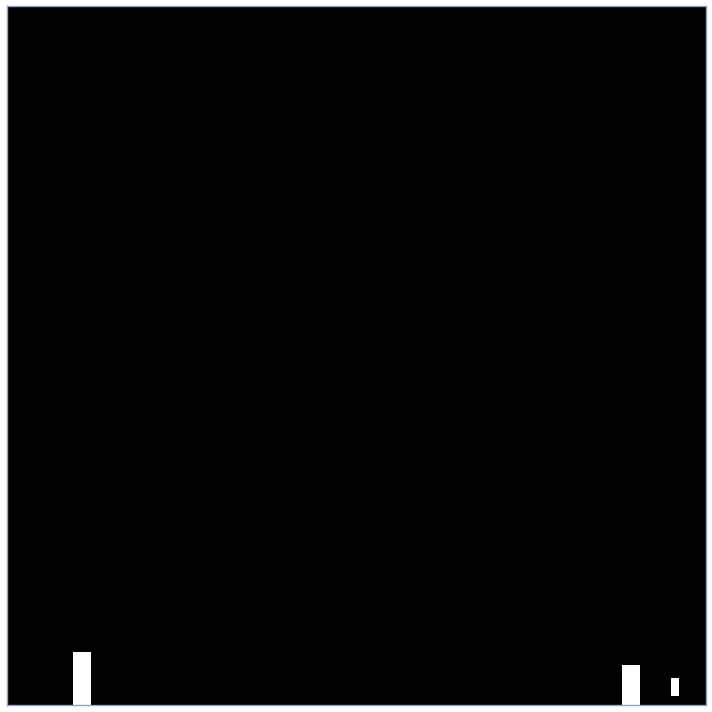

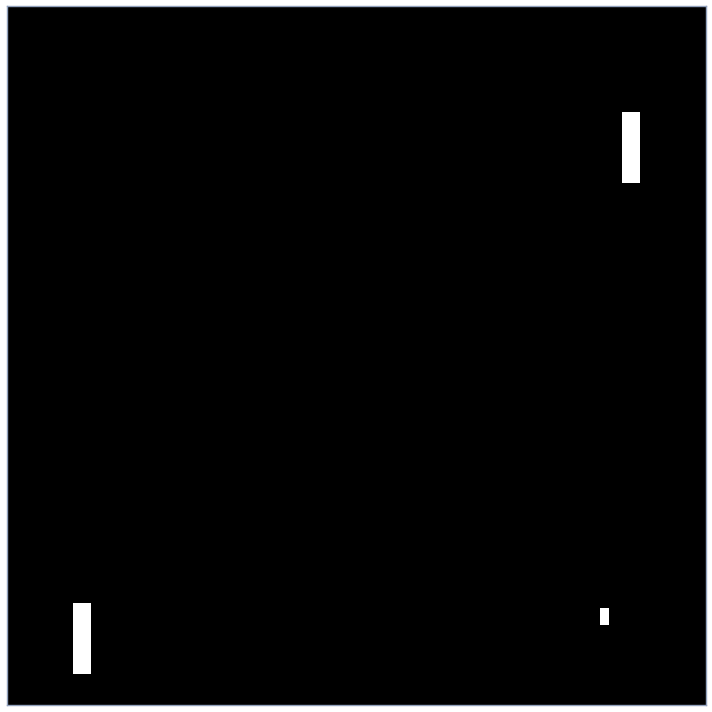

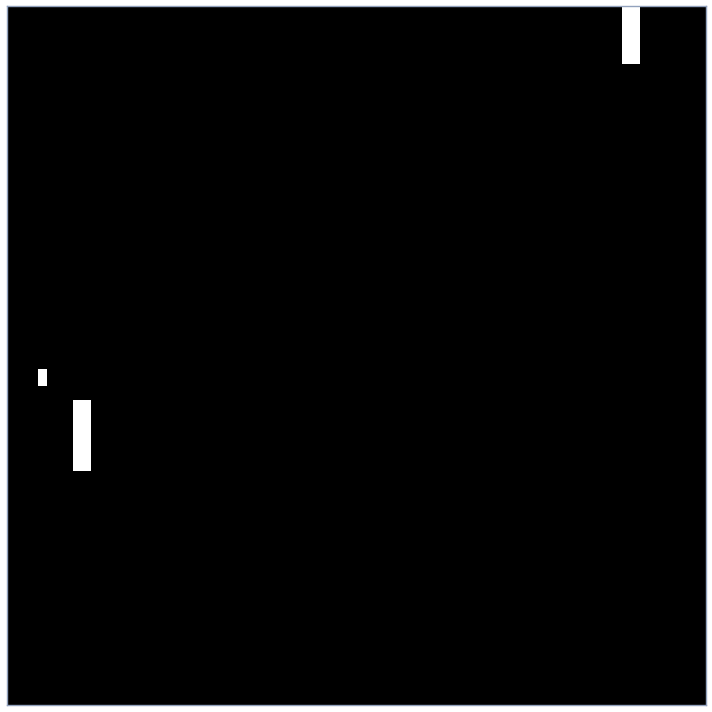

In [96]:
perm = np.random.permutation(len(y_train_reward))
cls_idx = -1
for i, rew in enumerate(y_train_reward[perm]):
    if rew == cls_idx:
        plot_image(paint_observation(
            x_train_obs[perm][i][-1]), pixel_range=(0, 255))
        cls_idx += 1

    if cls_idx == 2:
        break

## Create Network

In [97]:
clear_session()
obs_input = Input(shape=(p, 4), name='obs_input')
act_input = Input(shape=(p, 3), name='act_input')
merge_input = Concatenate(2)([obs_input, act_input])
bn_layer = BatchNormalization(axis=1)(merge_input)
bn_layer_flat = Flatten()(bn_layer)
lstm_layer = Dense(1024, activation='relu')(bn_layer_flat)
pred_obs = Dense(4, activation='tanh', name='pred_obs')(lstm_layer)
pred_reward = Dense(1, activation='tanh', name='pred_reward')(lstm_layer)
predictor = Model([obs_input, act_input], [pred_obs, pred_reward])
predictor.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
obs_input (InputLayer)           (None, 1, 4)          0                                            
____________________________________________________________________________________________________
act_input (InputLayer)           (None, 1, 3)          0                                            
____________________________________________________________________________________________________
concatenate_1 (Concatenate)      (None, 1, 7)          0           obs_input[0][0]                  
                                                                   act_input[0][0]                  
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 1, 7)          4           concatenate_1[0][0]     

In [98]:
predictor.compile('adam', ['mse', 'mse'])

In [99]:
history = {}

## Train Network

In [100]:
def fit_predictor(epochs=1, lr=1e-3):
    if exists(DIR_OUTPUT + '/predictor.h5'):
        predictor.load_weights(DIR_OUTPUT + '/predictor.h5')

    predictor.optimizer.lr = lr
    hist = predictor.fit([x_train_obs, x_train_act], [y_train_obs, y_train_reward], batch_size=256, epochs=epochs, verbose=0, callbacks=[
        TQDMNotebookCallback()], validation_data=([x_valid_obs, x_valid_act], [y_valid_obs, y_valid_reward]))
    predictor.save_weights(DIR_OUTPUT + '/predictor.h5')
    return hist.history

In [147]:
history = combine_dicts(history, fit_predictor(500, 1e-4))

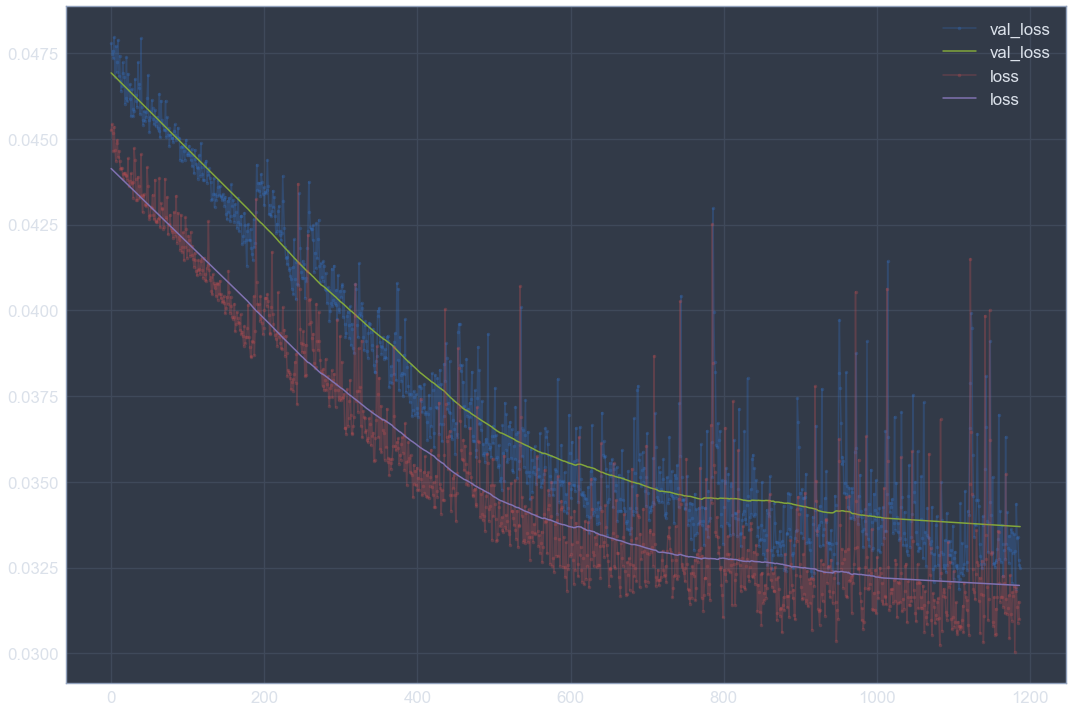

In [148]:
smooth_plot(history, keys=['loss', 'val_loss'], flags='retain')

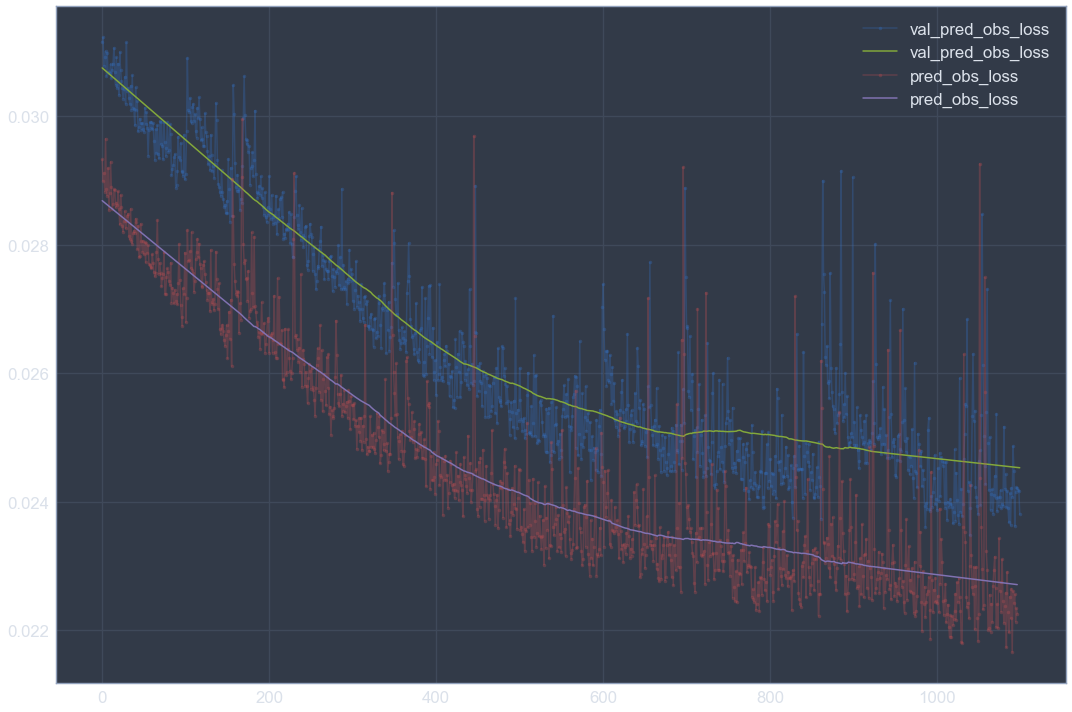

In [149]:
smooth_plot(history, keys=['pred_obs_loss', 'val_pred_obs_loss'], flags='retain')

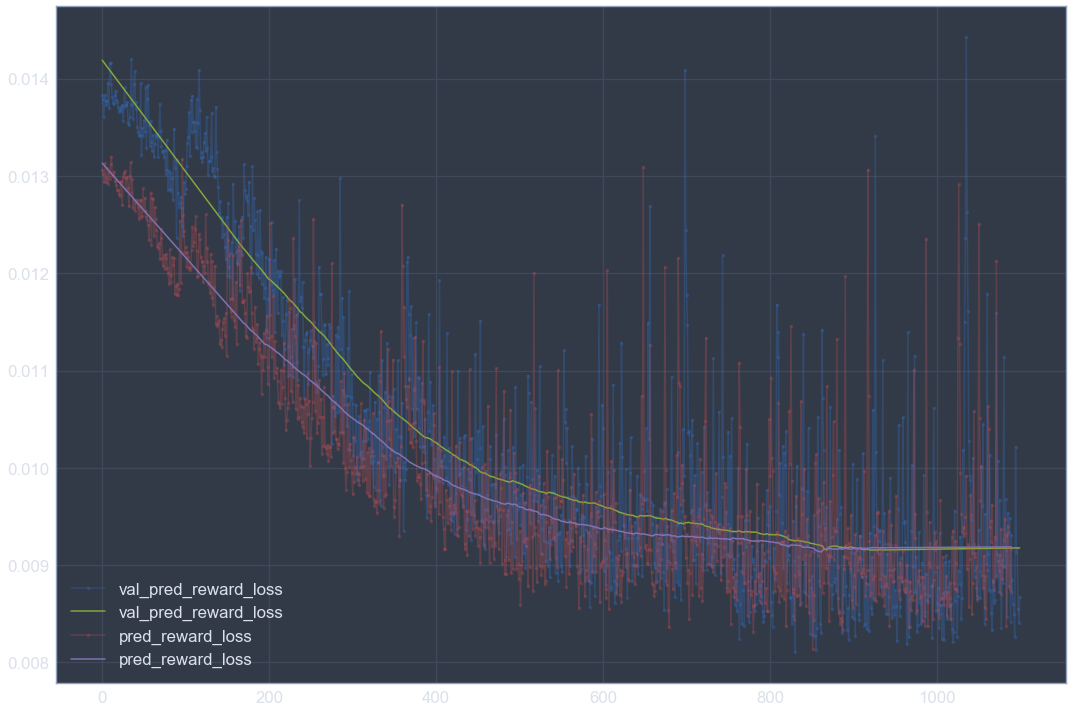

In [150]:
smooth_plot(history, keys=['pred_reward_loss', 'val_pred_reward_loss'], flags='retain')

## Test Network

In [151]:
n = 30
m = 30

In [152]:
sample_observations, _, _ = get_observations(n + m)

In [153]:
predicted_observations = sample_observations[:n]
predicted_rewards = []
reward_bars = [np.zeros((3, 158))] * n

In [154]:
for i in range(n, n + m):
    predicted_observation, predicted_reward = predictor.predict([
        np.stack([np.stack(predicted_observations[-p:])]), np.stack([np.random.multinomial(3, [1 / 3] * 3, p)])])
    predicted_observations.append(predicted_observation.squeeze())
    reward_bar = np.zeros((3, 158))
    predicted_rewards.append(predicted_reward.squeeze() * 0.5 + 0.5)
    reward_bar[:, :int(predicted_rewards[-1] * 158)] = 255
    reward_bars.append(reward_bar)

In [155]:
gif_imgs = []
for reward_bar, obs, pred in zip(reward_bars, sample_observations, predicted_observations):
    gif_imgs.append(np.vstack([np.vstack([reward_bar, paint_observation(pred)]),
                               paint_observation(obs)]))

In [156]:
gifsave(DIR_OUTPUT + '/future.gif', gif_imgs, 'gif')

/home/vaisakh/anaconda3/envs/tf/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [0.0, 255.0]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))


# Reward Network

## Prepare Data

In [12]:
def prepare_reward_data(t=None):
    train_observations, train_rewards, train_actions = get_observations(t)
    train_actions = to_categorical(train_actions)
    train_observations = np.stack(
        [np.hstack([obs, act]) for obs, act in zip(train_observations, train_actions)])
    train_rewards = np.stack(train_rewards)

    train_reward_neg_idx = np.where(train_rewards == -1)[0]
    train_reward_neut_idx = np.where(train_rewards != -1)[0]
    train_reward_neut_idx = train_reward_neut_idx[randint(
        5, len(train_reward_neut_idx - 5), len(train_reward_neg_idx))]

    x_train_neg = np.stack([np.stack(train_observations[i - 4:i + 1])
                            for i in train_reward_neg_idx])
    x_train_neut = np.stack([np.stack(train_observations[i - 4:i + 1])
                             for i in train_reward_neut_idx])
    x_train = np.vstack([x_train_neg, x_train_neut])

    y_train = np.zeros((len(x_train_neg) * 2))
    y_train[:len(x_train_neg)] = 1

    return x_train, y_train

In [13]:
x_train, y_train = prepare_reward_data(1e4)

In [14]:
x_valid, y_valid = prepare_reward_data(2e3)

In [15]:
x_train.shape, y_train.shape

((336, 5, 6), (336,))

In [16]:
x_valid.shape, y_valid.shape

((84, 5, 6), (84,))

## Create Network

In [58]:
pred_input = predictor.input
hidden = predictor.layers[1].output
pred_reward = Dense(1, activation='sigmoid')(hidden)
rewarder = Model(pred_input, pred_reward)

for layer in rewarder.layers[:-1]:
    layer.trainable = False

rewarder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1_input  (None, 5, 6)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 5, 6)              20        
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                1472      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 1,509
Trainable params: 17
Non-trainable params: 1,492
_________________________________________________________________


In [59]:
rewarder.compile('adam', 'binary_crossentropy')

## Train Network

In [60]:
def fit_rewarder(epochs=1, lr=1e-3):
    if exists(DIR_OUTPUT + '/rewarder.h5'):
        rewarder.load_weights(DIR_OUTPUT + '/rewarder.h5')

    rewarder.optimizer.lr = lr
    hist = rewarder.fit(x_train, y_train, batch_size=256, epochs=epochs, verbose=0, callbacks=[
        TQDMNotebookCallback()], validation_data=(x_valid, y_valid))
    rewarder.save_weights(DIR_OUTPUT + '/rewarder.h5')
    return hist

In [65]:
hist = fit_rewarder(250, 1e-5)

(0.068418235367252708, 0.15565573871135713)

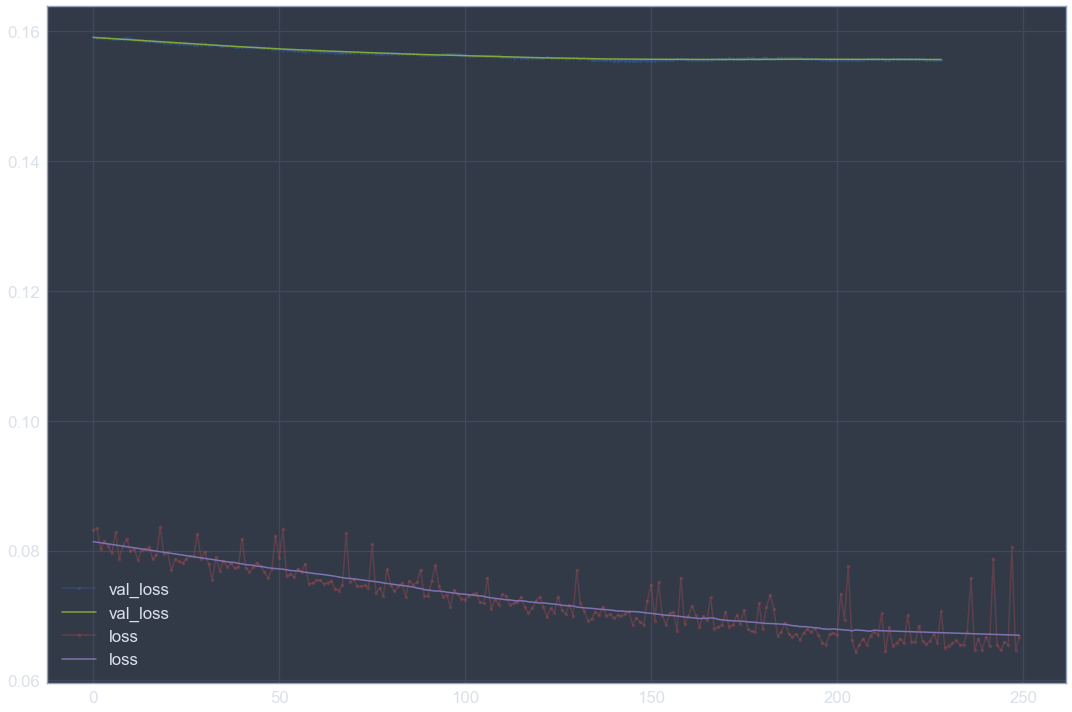

In [66]:
smooth_plot(hist.history, flags='retain')
np.array(hist.history['loss']
         )[-10:].mean(), np.array(hist.history['val_loss'])[-10:].mean()

## Test Network

In [73]:
n = 300

In [74]:
sample_observations, _, sample_actions = get_observations(n)
pred_rewards = []
reward_bars = [np.zeros((3, 158))] * 4

In [75]:
sample_actions = to_categorical(sample_actions)
sample_observations = np.stack(
    [np.hstack([obs, act]) for obs, act in zip(sample_observations, sample_actions)])

In [76]:
for i in range(5, n):
    pred_reward = rewarder.predict(
        np.stack([np.stack(sample_observations[i - 5:i])])).squeeze()
    pred_rewards.append(pred_reward)
    reward_bar = np.zeros((3, 158))
    reward_bar[:, :int(pred_reward * 158)] = 255
    reward_bars.append(reward_bar)

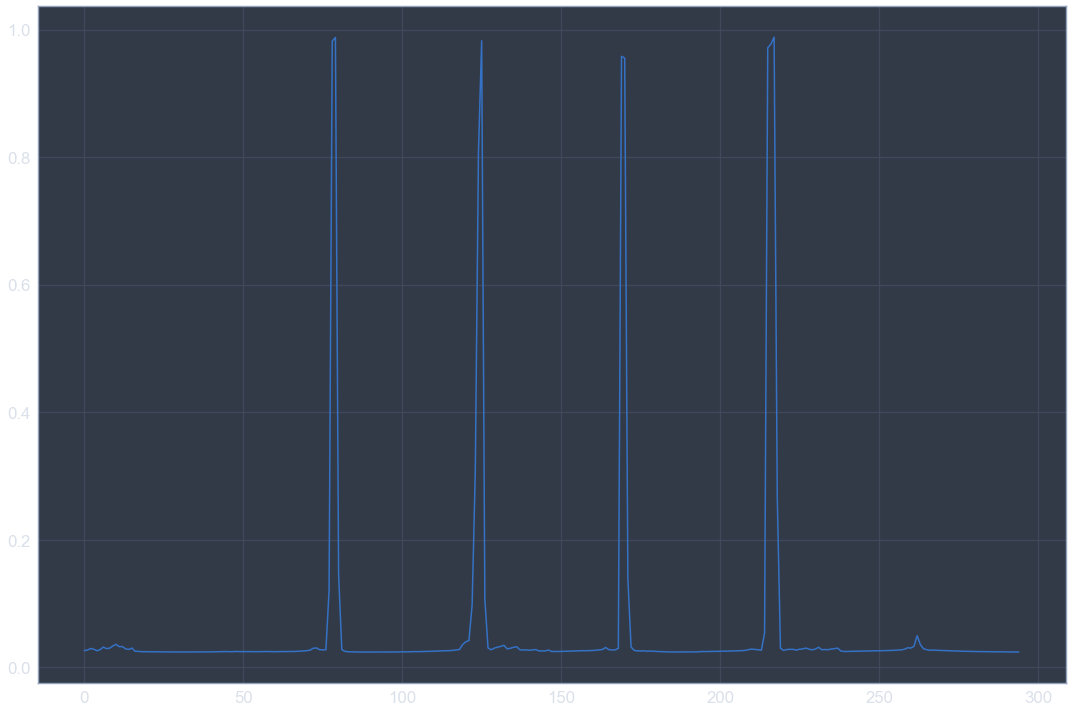

In [77]:
plot(pred_rewards)

In [78]:
gifsave(DIR_OUTPUT + '/reward.gif', [np.vstack([reward_bar, paint_observation(obs[:4])])
                                     for reward_bar, obs in zip(reward_bars, sample_observations)], 'gif')

/home/vaisakh/anaconda3/envs/tf/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [0.0, 255.0]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))


# Use network to plan

In [123]:
def get_predicted_observations(observations, num_steps=5, actions=None):
    if actions is None:
        actions = np.random.multinomial(1, [0.5] * 2, num_steps)

    predicted_observations = observations[:]
    for i in range(num_steps):
        predicted_observation = np.zeros(6)
        predicted_observation[:4] = predictor.predict(
            np.stack([np.stack(predicted_observations[-num_steps:])])).squeeze()
        predicted_observation[-2:] = actions[i]
        predicted_observations.append(predicted_observation)

    return predicted_observations[-num_steps:]

In [127]:
env.reset()
observations = []
for _ in range(30):
    observations.append(np.hstack(
        [refine_observation(env.step(denorm_action(0))[0]), randint(0, 1, 2)]))

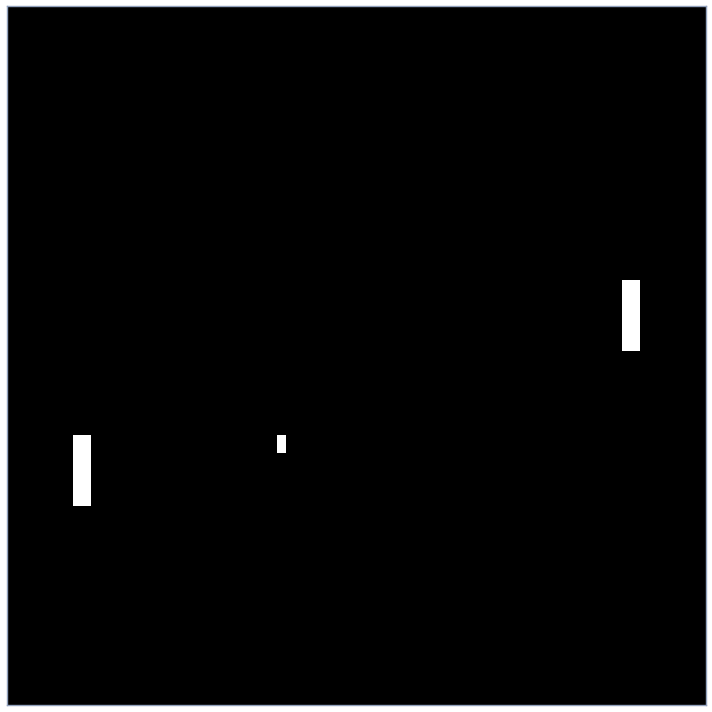

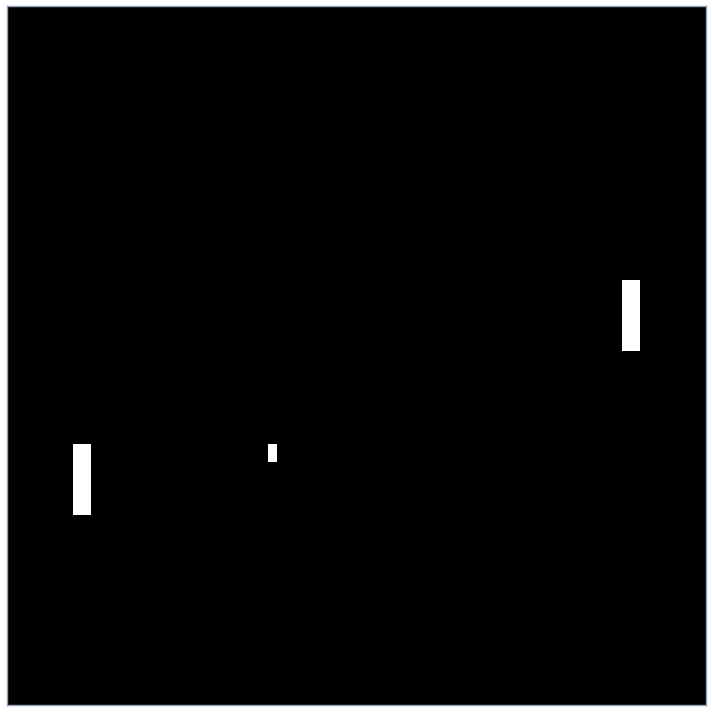

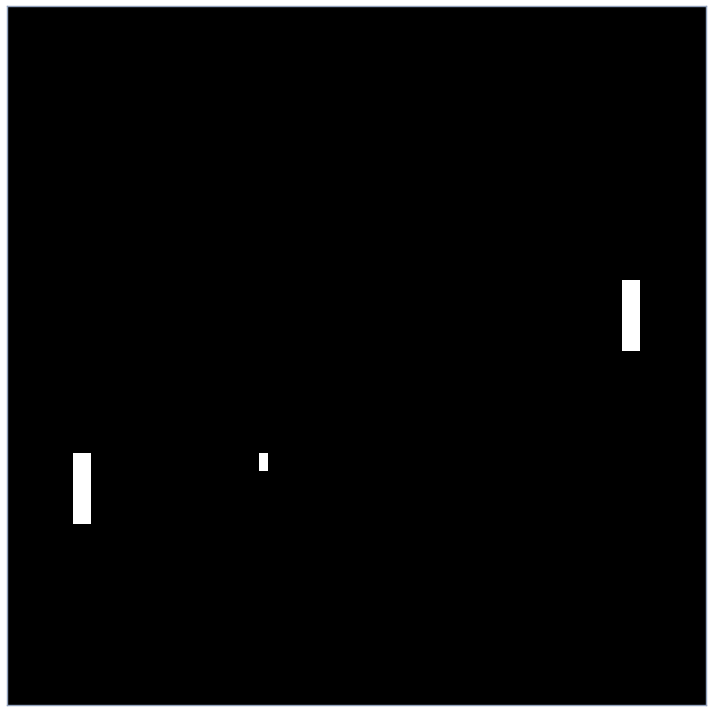

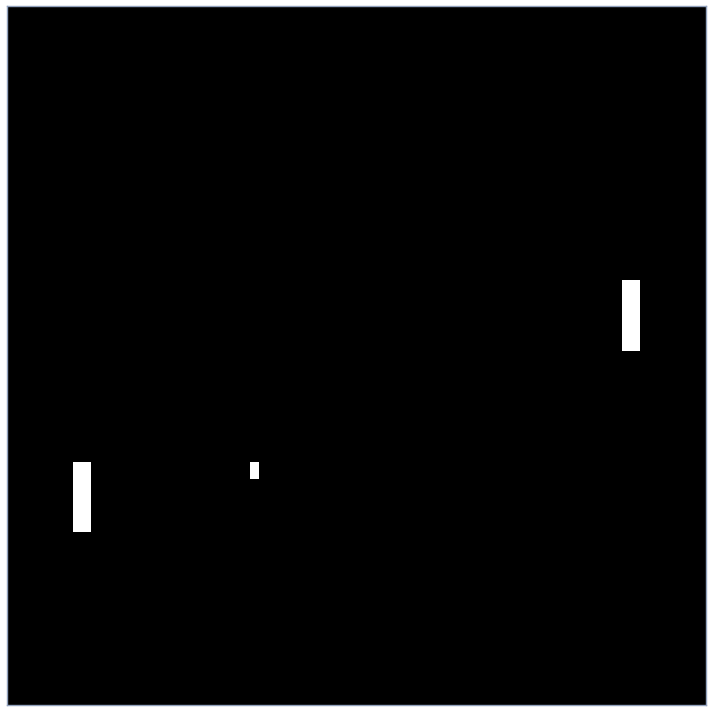

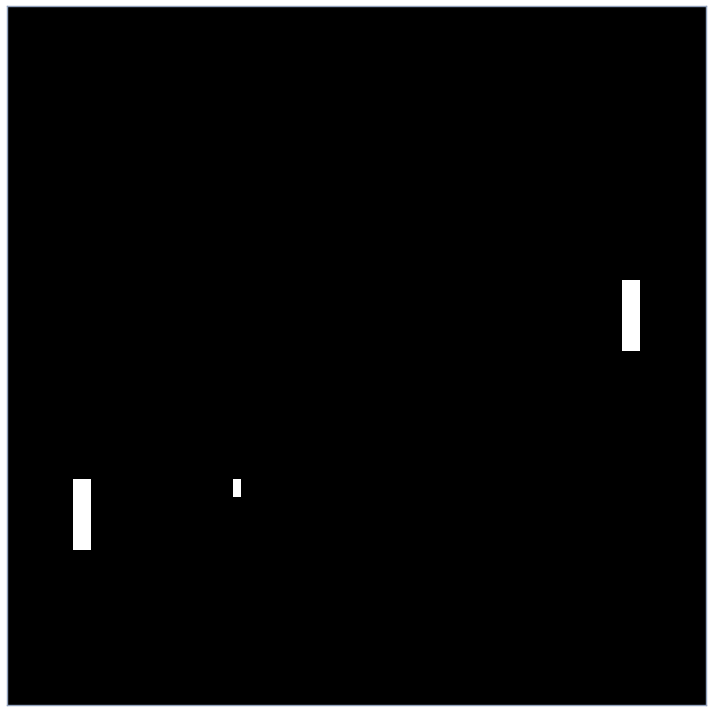

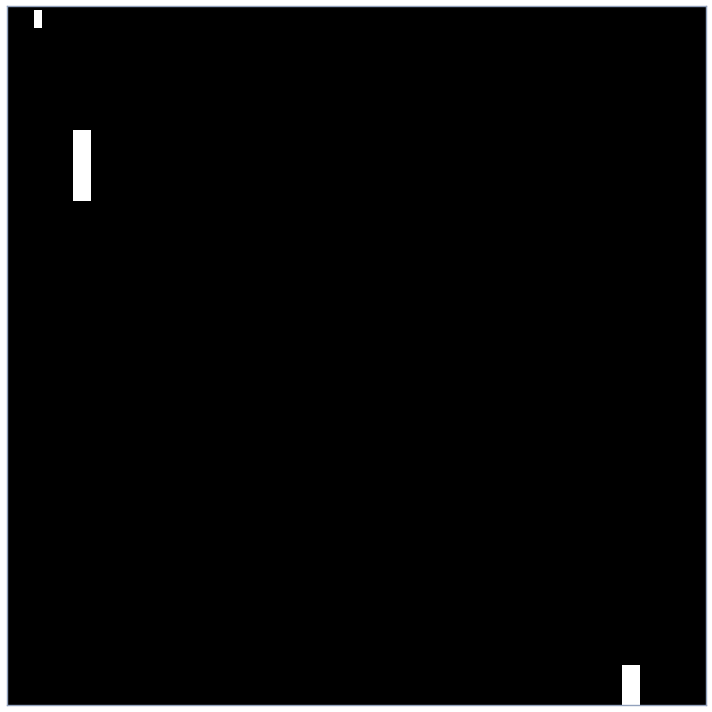

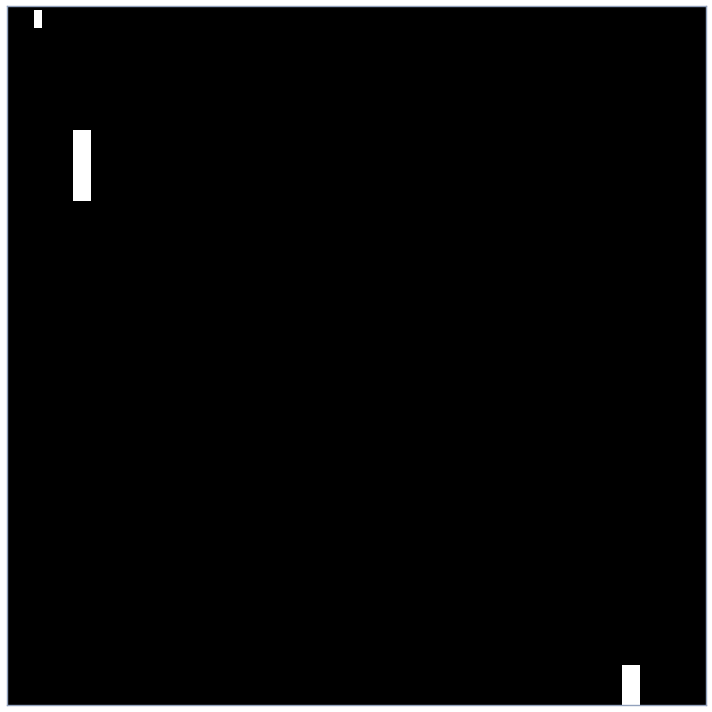

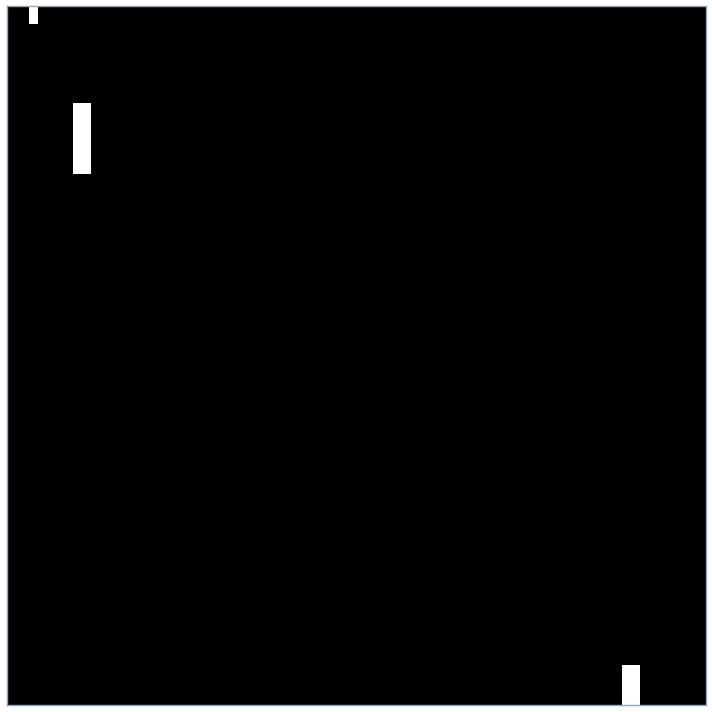

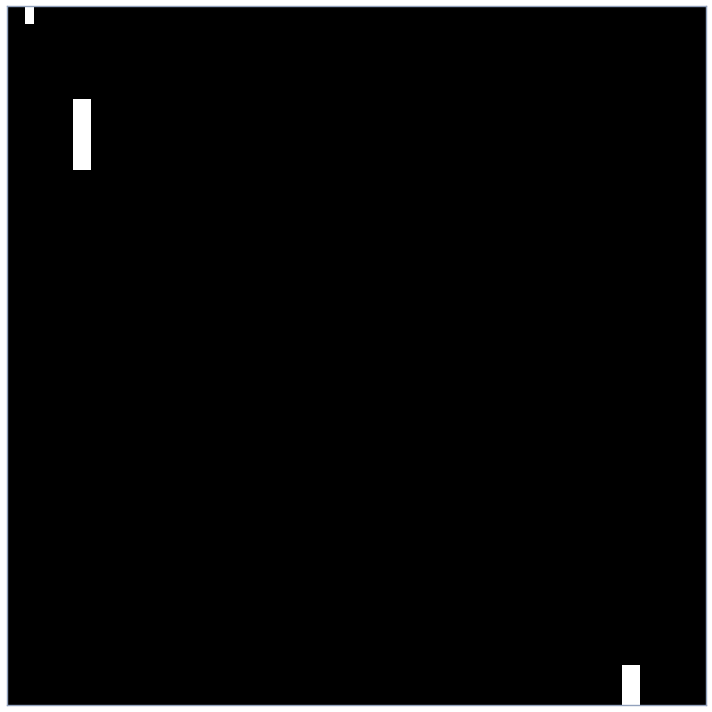

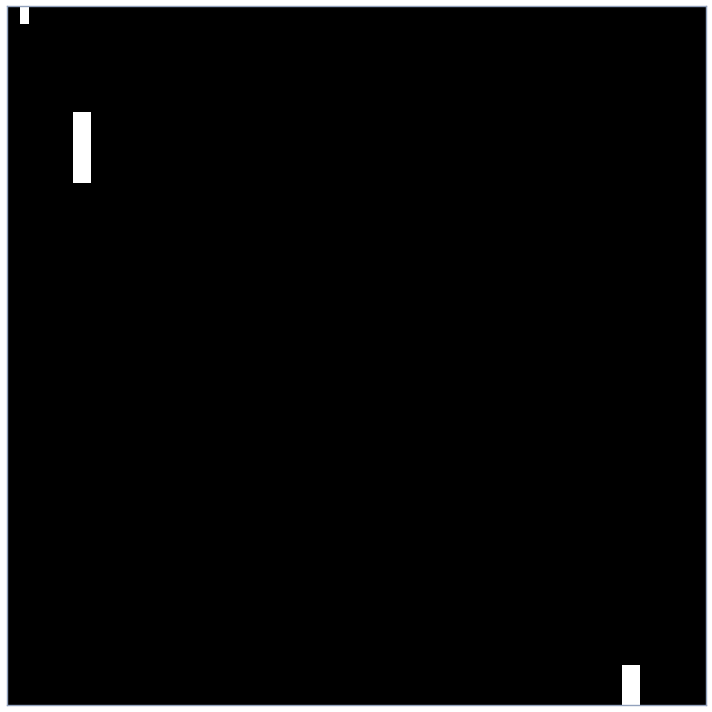

In [128]:
for obs in observations[-5:]:
    plot_image(paint_observation(obs[:4]), pixel_range=(0, 255))
for obs in get_predicted_observations(observations):
    plot_image(paint_observation(obs[:4]), pixel_range=(0, 255))

In [193]:
def get_policy(observations, num_steps=5, it_range=5, strength=1):
    actions = np.random.multinomial(1, [0.5] * 2, num_steps).astype('float64')
    predicted_observations = get_predicted_observations(
        observations, num_steps, actions)

    input_x = rewarder.input
    pred_reward = rewarder.output

    loss = pred_reward[0]
    grads = K.gradients(loss, input_x)[0][0, :, :2]

    iterate = K.function([input_x, K.learning_phase()], [loss, grads])

    for _ in range(it_range):
        for i in range(num_steps):
            predicted_observations = get_predicted_observations(
                observations, num_steps, actions)
        loss_value, grads_value = iterate(
            [np.stack([np.stack(predicted_observations)]), False])
        print(loss_value[0], grads_value.mean())
        actions -= grads_value * strength

    return actions.argmax(1)

In [194]:
get_policy(observations)

array([1, 0, 0, 0, 0])

In [185]:
def run_env(num_points=-1, flags=[]):
    points_played = 0
    reward = 0
    start_time = time()

    observations = []
    env.reset()
    while True:
        if 'render' in flags:
            env.render()

        if len(observations) < 5:
            action = randint(1, 3)
        else:
            action = get_policy(observations)[0]

        observation, r, done, _ = env.step(denorm_action(action))
        reward += r

        observations.append(np.hstack(
            [refine_observation(observation), to_categorical(action - 1, 2).squeeze()]))

        if 'verbose' in flags:
            print("Point:{}, Reward: {}, Action: {}, Time: {}s".format(
                1 + points_played, np.round(reward / (1 + points_played), 2), meaning(action), int(time() - start_time)), end='\r', flush=True)
        if r != 0:
            points_played += 1
            if points_played == num_points:
                break

        if done:
            break

    return reward / points_played

In [186]:
run_env(1, 'verbose')

KeyboardInterrupt: 